# Enhancing Deep Fake Detection in Multimedia: A Fusion of CNN and RNN Approaches

An RNN model is employed for the identification of artificially generated media

https://www.kaggle.com/datasets/reubensuju/celeb-df-v2?select=Celeb-synthesis

## Importing the Libraries

In [1]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

## Setting the Path to Dataset

In [ ]:
dataset = pd.read_csv("/Path/metadata_celeb.csv")
fake_count = sum(dataset['label'] == 'fake')
real_count = sum(dataset['label'] == 'real')
print(fake_count, real_count)

sample_size = 500
split_group = dataset.groupby('label')
sampled = split_group.apply(lambda x: x.sample(sample_size, random_state=50))
sample_dataset = sampled.reset_index(drop=True)
print(sample_dataset)

IMG_SIZE = 224
BATCH_SIZE = 64
EPOCHS = 10
MAX_SEQ_LENGTH = 20
NUM_FEATURES = 2048

video_folder = '/Path/Celeb-videos'

def load_video(path, max_frames=0, resize=(IMG_SIZE, IMG_SIZE)):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = face_crop(frame)
            frame = cv2.resize(frame, resize)
            frame = frame[:, :, [2, 1, 0]]
            frames.append(frame)
            if len(frames) == max_frames:
                break
    finally:
        cap.release()

    return np.array(frames)

def face_crop(frame):
    y, x = frame.shape[0:2]
    min_dim = min(y, x)
    start_x = (x // 2) - (min_dim // 2)
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y : start_y + min_dim, start_x : start_x + min_dim]

def inception_feature():
    inception_feature_extractor = keras.applications.InceptionV3(
        weights = "imagenet",
        include_top = False,
        pooling = "avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    preprocess_input = keras.applications.inception_v3.preprocess_input
    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)
    outputs = inception_feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name = "inception_feature_extractor")

feature_extractor = inception_feature()

1704 590
             video_name label
0    id23_id29_0009.mp4  fake
1    id52_id53_0001.mp4  fake
2     id7_id11_0002.mp4  fake
3    id24_id27_0009.mp4  fake
4    id19_id24_0000.mp4  fake
..                  ...   ...
995       id40_0002.mp4  real
996       id49_0000.mp4  real
997       id25_0004.mp4  real
998       id35_0005.mp4  real
999       id60_0005.mp4  real

[1000 rows x 2 columns]
87910968/87910968 [==============================] - 1s 0us/step


In [ ]:
label_processor = keras.layers.StringLookup(num_oov_indices=0, vocabulary=np.unique(
dataset["label"]))
print(label_processor.get_vocabulary())

labels = dataset["label"].values
labels = label_processor(labels[..., None]).numpy()
labels

['fake', 'real']


array([[1],
       [1],
       [1],
       ...,
       [0],
       [0],
       [0]])

## Data Augmentation And Preprocessing

In [ ]:
data_augmentation = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range = 20,
    horizontal_flip = True,
    zoom_range = 0.2,
    width_shift_range = 0.1,
    height_shift_range = 0.1
)

def preprocessing(df, root_dir):
    num_samples = len(df)
    video_paths = df["video_name"].values
    labels = df["label"].values
    labels = label_processor(labels[..., None]).numpy()

    frame_masks = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH), dtype="bool")
    frame_features = np.zeros(
        shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")


    for idx, path in enumerate(video_paths):
        
        path = str(path)
        frames = load_video(os.path.join(root_dir, path), max_frames=MAX_SEQ_LENGTH, resize=(IMG_SIZE, IMG_SIZE))
        frames = frames[None, ...]
        print(os.path.join(root_dir, path))

        temp_frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")#not masked 1 -> fake -> false
        temp_frame_features = np.zeros(
            shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
        )

        for i, batch in enumerate(frames):
            video_length = batch.shape[0]
            length = min(MAX_SEQ_LENGTH, video_length)

            batch = np.stack([data_augmentation.random_transform(frame) for frame in batch])

            for j in range(length):
                temp_frame_features[i, j, :] = feature_extractor.predict(
                    batch[None, j, :]
                )
            temp_frame_mask[i, :length] = 1

        frame_features[idx,] = temp_frame_features.squeeze()
        frame_masks[idx,] = temp_frame_mask.squeeze()

    return (frame_features, frame_masks), labels

## Splitting the Dataset

In [ ]:
root_dir = "/Path/Celeb-videos"
Train_set, Test_set = train_test_split(sample_dataset, test_size = 0.5, random_state=42, stratify=sample_dataset['label'])
Train_set, Val_set = train_test_split(sample_dataset, test_size = 0.5, random_state=42, stratify=sample_dataset['label'])
train_data, train_labels = preprocessing(Train_set,root_dir)
val_data , val_labels = preprocessing(Val_set,root_dir)
test_data, test_labels = preprocessing(Test_set,root_dir)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 143ms/step
/content/drive/MyDrive/Celeb-videos/id8_0006.mp4
1/1 [==============================] - 0s 143ms/step
/content/drive/MyDrive/Celeb-videos/id37_id29_0005.mp4
1/1 [==============================] - 0s 259ms/step
/content/drive/MyDrive/Celeb-videos/id38_id35_0002.mp4
1/1 [==============================] - 0s 150ms/step
/content/drive/MyDrive/Celeb-videos/id19_id23_0004.mp4
1/1 [==============================] - 0s 147ms/step
/content/drive/MyDrive/Celeb-videos/id16_0006.mp4
1/1 [==============================] - 0s 258ms/step
/content/drive/MyDrive/Celeb-videos/id46_0000.mp4
1/1 [==============================] - 0s 162ms/step
/content/drive/MyDrive/Celeb-videos/id10_0007.mp4
1/1 [==============================] - 0s 158ms/step
/content/drive/MyDrive/Celeb-videos/id28_id27_0008.mp4
1/1 [==============================] - 0s 150ms/step
/content/drive/MyDrive/Celeb-videos/id7_0004.mp4
1/1 

## Builting the RNN Architecture

In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 64
EPOCHS = 10
MAX_SEQ_LENGTH = 20
NUM_FEATURES = 2048
frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))

mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype = "bool")

x = keras.layers.GRU(16, return_sequences = True)(
    frame_features_input, mask=mask_input
)
x = keras.layers.GRU(8)(x)
x = keras.layers.Dropout(0.4)(x)
x = keras.layers.Dense(8, activation="relu")(x)

output = keras.layers.Dense(1, activation = "sigmoid")(x)
DFDV = keras.Model([frame_features_input, mask_input], output)

#Compiling the Model
DFDV.compile(loss="binary_crossentropy", optimizer = "adam", metrics = ["accuracy"])
DFDV.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 20, 2048)]   0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 20)]         0           []                               
                                                                                                  
 gru (GRU)                      (None, 20, 16)       99168       ['input_3[0][0]',                
                                                                  'input_4[0][0]']                
                                                                                                  
 gru_1 (GRU)                    (None, 8)            624         ['gru[0][0]']                

## RNN Model

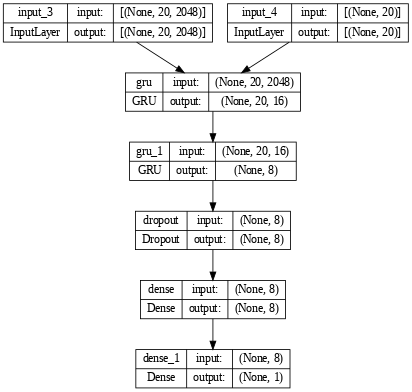

In [ ]:
keras.utils.plot_model(DFDV, expand_nested = True, dpi = 60, show_shapes = True)

## Training the Model

In [ ]:
checkpoint = keras.callbacks.ModelCheckpoint('./', save_weights_only = True, save_best_only = True)
history = DFDV.fit([train_data[0], train_data[1]],
                   train_labels,
                   validation_data = ([val_data[0], test_data[1]],val_labels)
                   callbacks = [checkpoint],
                   epochs = 10,
                   batch_size = 50)

Epoch 1/10
10/10 [==============================] - 1s 112ms/step - loss: 0.6487 - accuracy: 0.6440 - val_loss: 0.6511 - val_accuracy: 0.6440
Epoch 2/10
10/10 [==============================] - 1s 74ms/step - loss: 0.6352 - accuracy: 0.6740 - val_loss: 0.6541 - val_accuracy: 0.6400
Epoch 3/10
10/10 [==============================] - 1s 82ms/step - loss: 0.6211 - accuracy: 0.6860 - val_loss: 0.6445 - val_accuracy: 0.6420
Epoch 4/10
10/10 [==============================] - 1s 74ms/step - loss: 0.5974 - accuracy: 0.7380 - val_loss: 0.6413 - val_accuracy: 0.6300
Epoch 5/10
10/10 [==============================] - 1s 74ms/step - loss: 0.5877 - accuracy: 0.7340 - val_loss: 0.6382 - val_accuracy: 0.6180
Epoch 6/10
10/10 [==============================] - 1s 85ms/step - loss: 0.5743 - accuracy: 0.7400 - val_loss: 0.6403 - val_accuracy: 0.6400
Epoch 7/10
10/10 [==============================] - 1s 75ms/step - loss: 0.5843 - accuracy: 0.7120 - val_loss: 0.6771 - val_accuracy: 0.6080
Epoch 8/10
1

## Evaluating the Model

In [ ]:
y_pred = DFDV.predict([test_data[0], test_data[1]])
y_true = test_labels
y_pred = DFDV.predict([test_data[0], test_data[1]])
y_pred = np.round(y_pred).flatten()

print("Classification Report:")
print(classification_report(y_true, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

16/16 [==============================] - 0s 19ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.63      0.64       250
           1       0.64      0.66      0.65       250

    accuracy                           0.65       500
   macro avg       0.65      0.65      0.65       500
weighted avg       0.65      0.65      0.65       500

Confusion Matrix:
[[158  92]
 [ 84 166]]


## Predicting the Values

In [ ]:
y_pred = (y_pred > 0.5)
print("Accuracy: ", accuracy_score(test_labels, y_pred))
print("Precision: ", precision_score(test_labels, y_pred))
print("Recall: ", recall_score(test_labels, y_pred))
print("F1 Score: ", f1_score(test_labels, y_pred))

Accuracy:  0.648
Precision:  0.6434108527131783
Recall:  0.664
F1 Score:  0.6535433070866143


## Plotting the Curves

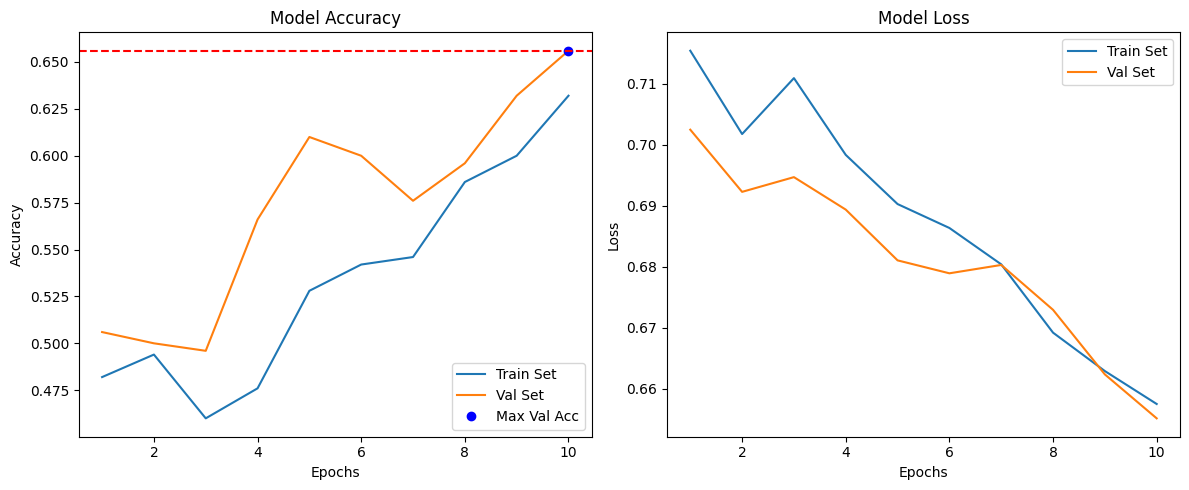

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)
val_acc_max = max(history.history['val_accuracy'])
val_acc_max_idx = history.history['val_accuracy'].index(val_acc_max) + 1
plt.figure(figsize=(12, 5))

#Model Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.plot(val_acc_max_idx, val_acc_max, 'bo', label='Max Val Acc')
plt.axhline(y=val_acc_max, color='r', linestyle='--')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

#Model Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

## Confusion Matrix

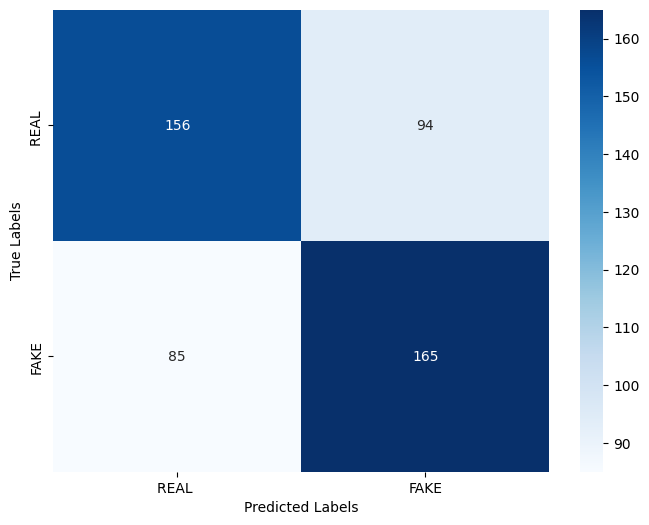

In [ ]:
conf_mat = confusion_matrix(y_true, y_pred)
class_labels = ['REAL ', 'FAKE']
fig, ax = plt.subplots(figsize = (8, 6))
sns.heatmap(conf_mat, annot = True, fmt = 'd', xticklabels = class_labels, yticklabels = class_labels, cmap = 'Blues')
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
plt.show()